In [ ]:
# init repo notebook
!git clone https://github.com/rramosp/ppdl.git > /dev/null 2> /dev/null
!mv -n ppdl/content/init.py ppdl/content/local . 2> /dev/null
!pip install -r ppdl/content/requirements.txt > /dev/null

# High level models with Keras


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
%load_ext tensorboard

from sklearn.datasets import *
from local.lib import mlutils
from IPython.display import Image
tf.__version__

ImportError: cannot import name 'mlutils' from 'local.lib' (unknown location)

## Implementing linear regresion in TF


(150, 1) (150,)


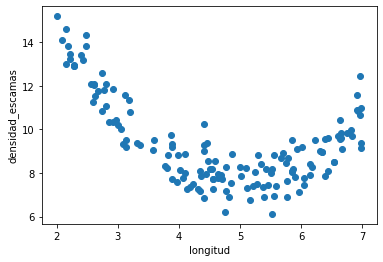

In [2]:
d = pd.read_csv("local/data/trilotropicos.csv")
y = d.densidad_escamas.values.astype(np.float32)
X = np.r_[[d.longitud.values]].T.astype(np.float32)

print(X.shape, y.shape)
plt.scatter(d.longitud, d.densidad_escamas)
plt.xlabel(d.columns[0])
plt.ylabel(d.columns[1]);

In [3]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X,y)
lr.coef_, lr.intercept_

(array([-0.71805906], dtype=float32), 12.689999)

 ## Version 1: raw low level with gradient descent
 
- beware of typing. `tensorflow` is very sensitive to numeric data types (`tf.float32`, `tf.float64`, etc.) Default types in `numpy` and `tensorflow` might not always be the same

In [4]:
from progressbar import progressbar as pbar

epochs = 4000
learning_rate = 0.01

# symbolic variables
w = tf.Variable(np.random.normal(size=(X.shape[-1], 1), scale=.6), dtype=tf.float32)
b = tf.Variable(np.random.normal(size=(1,), scale=.6), dtype=tf.float32)
h = []

#optimization loop
for epoch in pbar(range(epochs)):
    with tf.GradientTape() as t:
        preds = tf.matmul(X,w)+b
        loss = tf.reduce_mean( (preds-y.reshape(-1,1))**2)
        
    gw, gb = t.gradient(loss, [w, b])
    
    w.assign_sub(learning_rate * gw)
    b.assign_sub(learning_rate * gb)
    
    h.append([gw.numpy()[0][0], gb.numpy()[0], w.numpy()[0][0], b.numpy()[0], loss.numpy()])
h = np.r_[h]
print (b.numpy(), w.numpy())

2022-05-06 14:42:05.321330: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 14:42:05.596433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 14:42:05.597123: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 14:42:05.601519: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

[12.677922] [[-0.7156864]]


(0.0, 50.0)

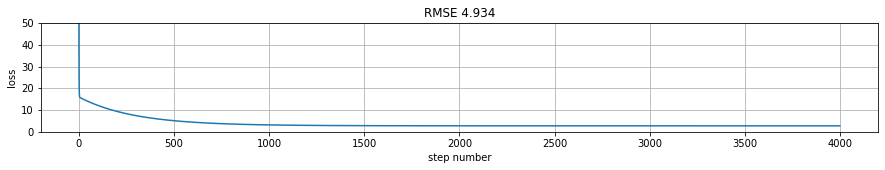

In [5]:
rmse = tf.reduce_mean((tf.matmul(X,w)+b-y)**2).numpy()
plt.figure(figsize=(15,2));
plt.plot(h[:,-1]); plt.xlabel("step number"); plt.ylabel("loss"); plt.grid();
plt.title("RMSE %.3f"%rmse);
plt.ylim(0,50)

## Version 2: using `tf.function` to speed up

In [6]:
epochs = 4000

# initialize weights
w.assign(np.random.normal(size=(X.shape[-1],1)).astype(np.float32)*.6) 
b.assign(np.random.normal(size=(1,)).astype(np.float32))

@tf.function
def get_gradient(w, b, X, y):
    with tf.GradientTape() as t:
        preds = tf.matmul(X,w)+b
        loss = tf.reduce_mean( (preds-y)**2)
        
    gw, gb = t.gradient(loss, [w, b])
    return gw, gb, loss

#optimization loop
h = []
for epoch in pbar(range(epochs)):
        
    gw, gb, loss = get_gradient(w, b, X, y.reshape(-1,1))
    
    w.assign_sub(learning_rate * gw)
    b.assign_sub(learning_rate * gb)

    h.append([gw.numpy()[0][0], gb.numpy()[0], w.numpy()[0][0], b.numpy()[0], loss.numpy()])
h = np.r_[h]

print (b.numpy(), w.numpy())

100% (4000 of 4000) |####################| Elapsed Time: 0:00:05 Time:  0:00:05


[12.678748] [[-0.7158488]]


(0.0, 50.0)

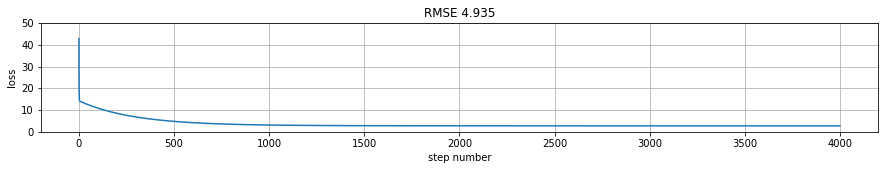

In [7]:
predictions = tf.matmul(X,w)+b

rmse = tf.reduce_mean((predictions-y)**2).numpy()
plt.figure(figsize=(15,2));
plt.plot(h[:,-1]); plt.xlabel("step number"); plt.ylabel("loss"); plt.grid();
plt.title("RMSE %.3f"%rmse);
plt.ylim(0,50)

## Version 3: using batches with random shuffling (stochastic gradient descent)

notice we tune the number of epochs as the number of weights updates increases

In [8]:
#optimization loop
batch_size = 16
epochs = 400

# initialize weights
w.assign(np.random.normal(size=(X.shape[-1],1))*.6) 
b.assign(np.random.normal(size=(1,)))

h = []

for epoch in pbar(range(epochs)):
    
    idxs = np.random.permutation(len(X))
    
    for step in range(len(X)//batch_size+((len(X)%batch_size)!=0)):
        
        X_batch = X[idxs][step*batch_size:(step+1)*batch_size]
        y_batch = y[idxs][step*batch_size:(step+1)*batch_size]
        
        gw, gb, loss = get_gradient(w, b, X_batch, y_batch.reshape(-1,1))

        w.assign_sub(learning_rate * gw)
        b.assign_sub(learning_rate * gb)
        
        h.append([gw.numpy()[0][0], gb.numpy()[0], w.numpy()[0][0], b.numpy()[0], loss.numpy()])
h = np.r_[h]
print (b.numpy(), w.numpy())

100% (400 of 400) |######################| Elapsed Time: 0:00:04 Time:  0:00:04


[12.676858] [[-0.68440795]]


(0.0, 50.0)

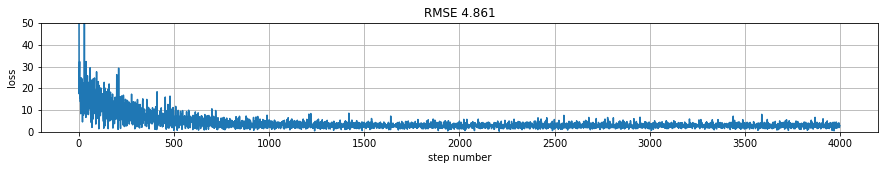

In [9]:
predictions = tf.matmul(X,w)+b

rmse = tf.reduce_mean((predictions-y)**2).numpy()
plt.figure(figsize=(15,2));
plt.plot(h[:,-1]); plt.xlabel("step number"); plt.ylabel("loss"); plt.grid();
plt.title("RMSE %.3f"%rmse);
plt.ylim(0,50)

## Version 4: packing up with Keras `class` API  and custom SGD

observe:

- the`build` method that is called by Keras whenever `input_shape` is known
- we use `add_weight` so that our model weights are known to the Keras model framework (`trainable_variables`, `get_weights`, etc.) 

see [here](https://www.tensorflow.org/guide/keras/custom_layers_and_models)

In [332]:
class LinearRegressionModel4(tf.keras.Model):
    
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], 1), initializer='random_normal',
                                 trainable=True, dtype=tf.float32)
        
        self.b = self.add_weight(shape=(1,), initializer='random_normal',
                                 trainable=True, dtype=tf.float32)
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
    @tf.function
    def get_gradient(self, X, y):
        with tf.GradientTape() as t:
            loss = tf.reduce_mean( (self(X)-y)**2)

        gw, gb = t.gradient(loss, [self.w, self.b])
        return gw, gb, loss

    def fit(self, X,y, epochs, batch_size=16, learning_rate=0.01):
        y = y.reshape(-1,1)
        self.h=[]
        for epoch in pbar(range(epochs)):
            idxs = np.random.permutation(len(X))
            for step in range(len(X)//batch_size+((len(X)%batch_size)!=0)):
                X_batch = X[idxs][step*batch_size:(step+1)*batch_size]
                y_batch = y[idxs][step*batch_size:(step+1)*batch_size]            

                gw, gb, loss = self.get_gradient(X_batch,y_batch)
                self.w.assign_sub(learning_rate * gw)
                self.b.assign_sub(learning_rate * gb)
                self.h.append([gw.numpy()[0][0], gb.numpy()[0], w.numpy()[0][0], b.numpy()[0], loss.numpy()])
        self.h = np.r_[self.h]


In [333]:
model = LinearRegressionModel4()

observe that we can use the object directly on data to get predictions

In [334]:
model(X[:2])

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-0.04066426],
       [-0.04316743]], dtype=float32)>

or with the  `.predict` method

In [335]:
model.predict(X[:2])

array([[-0.04066426],
       [-0.04316743]], dtype=float32)

In [336]:
model.trainable_variables

[<tf.Variable 'linear_regression_model4/Variable:0' shape=(1, 1) dtype=float32, numpy=array([[0.00150557]], dtype=float32)>,
 <tf.Variable 'linear_regression_model4/Variable:0' shape=(1,) dtype=float32, numpy=array([-0.0464113], dtype=float32)>]

In [337]:
model.get_weights()

[array([[0.00150557]], dtype=float32), array([-0.0464113], dtype=float32)]

and fit the model

In [338]:
model.fit(X, y, epochs=400, batch_size=16)

100% (400 of 400) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


In [339]:
model.b.numpy(), model.w.numpy()

(array([12.6924925], dtype=float32), array([[-0.5818763]], dtype=float32))

(0.0, 50.0)

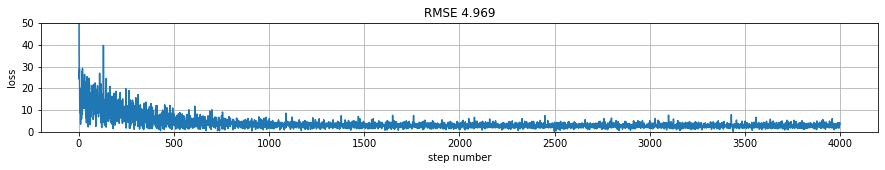

In [340]:
predictions = model(X)

rmse = tf.reduce_mean((predictions-y)**2).numpy()
plt.figure(figsize=(15,2));
plt.plot(model.h[:,-1]); plt.xlabel("step number"); plt.ylabel("loss"); plt.grid();
plt.title("RMSE %.3f"%rmse);
plt.ylim(0,50)

## Version 5: Sequential Keras model with standard loop

In [341]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
    
def get_model5():
    model = Sequential()
    model.add(Dense(1, input_shape=(X.shape[-1],), activation="linear"))
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), 
                  metrics=["mean_absolute_error"],
                  loss="mse")
# equivalent forms for loss    
#                  loss = lambda y_true, y_pred: tf.reduce_mean((y_true-y_pred)**2))
#                  loss="mean_squared_error")
#                  loss=tf.keras.metrics.mean_squared_error)
    return model

In [342]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,y.reshape(-1,1), test_size=0.2)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((120, 1), (30, 1), (120, 1), (30, 1))

In [343]:
!rm -rf logs
model = get_model5()

tb_callback = tf.keras.callbacks.TensorBoard('./logs', update_freq=1)
model.fit(X_train,y_train, epochs=100, batch_size=5, verbose=0, 
          callbacks=[tb_callback], validation_data=(X_val, y_val))

model.weights

[<tf.Variable 'dense_12/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-0.5444805]], dtype=float32)>,
 <tf.Variable 'dense_12/bias:0' shape=(1,) dtype=float32, numpy=array([11.90973], dtype=float32)>]

history is now logged only per epoch

In [344]:
model.history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

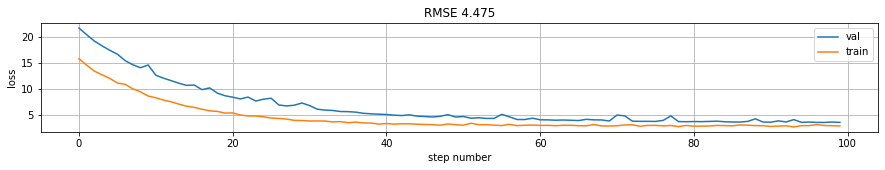

In [345]:
predictions = model(X)
rmse = np.mean((predictions-y)**2)

plt.figure(figsize=(15,2));
plt.plot(model.history.history["val_loss"], label="val"); 
plt.plot(model.history.history["loss"], label="train"); 
plt.xlabel("step number"); plt.ylabel("loss"); plt.grid();
plt.title("RMSE %.3f"%rmse); plt.legend();

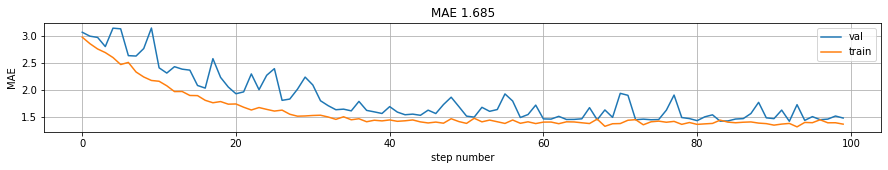

In [346]:
mae = np.mean(np.abs(predictions-y))

plt.figure(figsize=(15,2));
plt.plot(model.history.history["val_mean_absolute_error"], label="val"); 
plt.plot(model.history.history["mean_absolute_error"], label="train"); 
plt.xlabel("step number"); plt.ylabel("MAE"); plt.grid();
plt.title("MAE %.3f"%mae); plt.legend();

In [40]:
%tensorboard --logdir logs

## Version 6: Custom model with Keras `class` API  and standard loop

In [347]:
class LinearRegressionModel6(tf.keras.Model):
    
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True, dtype=np.float32)
        
        self.b = self.add_weight(shape=(1,),
                                 initializer='random_normal',
                                 trainable=True, dtype=np.float32)
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


In [401]:
model = LinearRegressionModel6()

In [348]:
!rm -rf logs
model = LinearRegressionModel6()
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.02), 
           loss="mse", metrics=['mean_absolute_error'])

tb_callback = tf.keras.callbacks.TensorBoard('./logs', update_freq=1)


model.fit(X_train,y_train, epochs=100, batch_size=5, callbacks=[tb_callback], 
       verbose=0, validation_data=(X_val, y_val))

In [349]:
model.b.numpy(), model.w.numpy()[0]

(array([12.178291], dtype=float32), array([-0.3399362], dtype=float32))

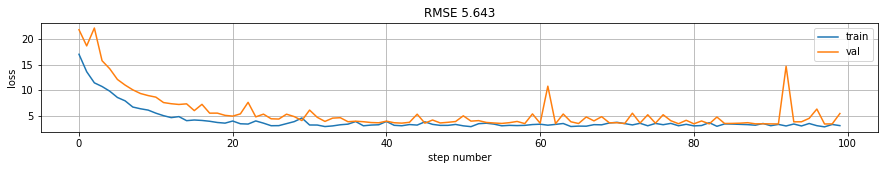

In [350]:
predictions = model(X)
rmse = np.mean((predictions-y)**2)

plt.figure(figsize=(15,2));
plt.plot(model.history.history["loss"], label="train"); 
plt.plot(model.history.history["val_loss"], label="val"); 
plt.xlabel("step number"); plt.ylabel("loss"); plt.grid();
plt.title("RMSE %.3f"%rmse); plt.legend();

## Version 7: Using `train_step` $\rightarrow$ control loss and gradients on a custom model.

In [355]:
class LinearRegressionModel7(tf.keras.Model):
    
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True, dtype=np.float32)
        
        self.b = self.add_weight(shape=(1,),
                                 initializer='random_normal',
                                 trainable=True, dtype=np.float32)
        
        self.loss_fn = tf.keras.metrics.MeanSquaredError()
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

    def test_step(self, data):
        # here we implement loss by hand
        return {'loss': tf.reduce_mean((self(X)-y)**2)  }
    
    @tf.function
    def train_step(self, data):
        X,y = data
        loss_fn = lambda y_true, y_preds: tf.reduce_mean((y_true-y_preds)**2)
        with tf.GradientTape() as tape:
            # we use tf.keras loss function (equivalent to test_step)
            loss_fn = tf.keras.metrics.mean_squared_error
            loss = tf.reduce_mean(loss_fn(y, self(X)))
            
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        
        return {'loss': loss}

In [ ]:
model = LinearRegressionModel7()
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.02))
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.035))
model.fit(X_train,y_train, epochs=400, batch_size=5, verbose=0, validation_data=(X_val, y_val))

In [359]:
[i.numpy() for i in model.trainable_variables]

[array([[-0.62764317]], dtype=float32), array([12.133042], dtype=float32)]

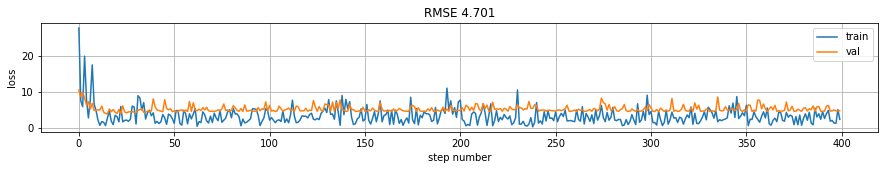

In [360]:
predictions = model(X)
rmse = np.mean((predictions-y)**2)

plt.figure(figsize=(15,2));
plt.plot(model.history.history["loss"], label="train"); 
plt.plot(model.history.history["val_loss"], label="val"); 
plt.xlabel("step number"); plt.ylabel("loss"); plt.grid();
plt.title("RMSE %.3f"%rmse); plt.legend();

## Version 8: Using `train_step` $\rightarrow$ control loss and gradients on a standard model.

observe that:

- we use a standard `Dense` layer, 
- we use a custom loss function and `optimizer.apply_gradients`

In [397]:

class CustomModel(tf.keras.Model):
    
    def test_step(self, data):
        return {'loss': tf.reduce_mean((self(X)-y)**2)}    
    
    @tf.function
    def train_step(self, data):
        X,y = data
        
        with tf.GradientTape() as tape:
            y_pred = self(X, training=True)
            loss_value = tf.reduce_mean((y_pred-y)**2)
            
        grads = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        
        return {'loss': loss_value}


In [398]:
from tensorflow.keras.layers import Dense, Input
    
def get_model8():
    
    inputs = tf.keras.layers.Input(shape=(1))
    outputs = tf.keras.layers.Dense(1, activation="linear")(inputs)
    
    model = CustomModel(inputs, outputs)
    
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.02))
    return model

our custom loop (**for any model** !!!)

In [375]:
model = get_model8()
model.summary()

Model: "custom_model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [376]:
model.weights

[<tf.Variable 'dense_15/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.79911673]], dtype=float32)>,
 <tf.Variable 'dense_15/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [377]:
model.trainable_variables

[<tf.Variable 'dense_15/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.79911673]], dtype=float32)>,
 <tf.Variable 'dense_15/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [378]:
model.fit(X_train,y_train.reshape(-1,1), epochs=400, batch_size=5, verbose=0, validation_data=(X_val, y_val))

In [379]:
model.trainable_variables

[<tf.Variable 'dense_15/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-0.4444475]], dtype=float32)>,
 <tf.Variable 'dense_15/bias:0' shape=(1,) dtype=float32, numpy=array([11.331306], dtype=float32)>]

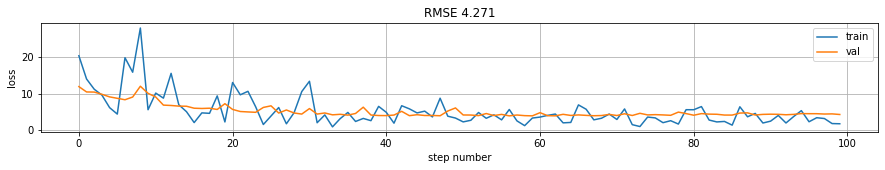

In [380]:
predictions = model(X)
rmse = np.mean((predictions-y)**2)

plt.figure(figsize=(15,2));
plt.plot(model.history.history["loss"], label="train"); 
plt.plot(model.history.history["val_loss"], label="val"); 
plt.xlabel("step number"); plt.ylabel("loss"); plt.grid();
plt.title("RMSE %.3f"%rmse); plt.legend();

## Version 9: using `train_on_batch` $\rightarrow$ control data

In [393]:
epochs = 400
batch_size = 5

In [394]:
model = get_model8()
h = []
for epoch in pbar(range(epochs)):
    idxs = np.random.permutation(len(X))
    for step in range(len(X)//batch_size+((len(X)%batch_size)!=0)):
        X_batch = X[idxs][step*batch_size:(step+1)*batch_size]
        y_batch = y[idxs][step*batch_size:(step+1)*batch_size]       
        model.train_on_batch(X_batch, y_batch)
    h.append(model.test_step([X_batch, y_batch])['loss'])

100% (400 of 400) |######################| Elapsed Time: 0:00:24 Time:  0:00:24


In [395]:
model.trainable_variables

[<tf.Variable 'dense_22/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.14408377]], dtype=float32)>,
 <tf.Variable 'dense_22/bias:0' shape=(1,) dtype=float32, numpy=array([10.004782], dtype=float32)>]

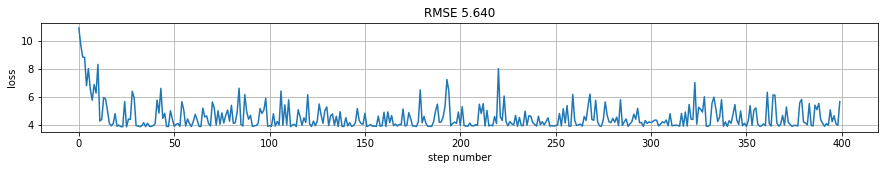

In [396]:
predictions = model(X)

rmse = tf.reduce_mean((predictions-y)**2).numpy()
plt.figure(figsize=(15,2));
plt.plot(h); plt.xlabel("step number"); plt.ylabel("loss"); plt.grid();
plt.title("RMSE %.3f"%rmse);